In [1]:
import torch
import pyro

from typing import Dict, List
from scipy.stats import entropy
from scipy.stats import beta
import pyro.distributions as dist

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# this is just a definition of a function that we will be using for sampling from the model and 
# creating plots of the samples

def plot_from_nodes(nodes, filters: Dict[str, float] = None, nodes_to_plot: List[str] = None, bins = 20):

    """
   The plot_from_nodes function takes a dictionary of nodes, processes their values, optionally filters the data,
    and plots histograms for specified nodes. The function then returns the processed DataFrame.
    Parameters:
    - nodes: Dictionary of nodes containing data.
    - filters: Optional dictionary to filter the data based on specified conditions.
    - nodes_to_plot: Optional list of specific nodes to plot. If not provided, plots all nodes.
    - bins: Number of bins for the histograms (default is 20).

    Returns:
    - DataFrame of the processed values.
    """

    values = {key: nodes[key]['value'].float().flatten().detach().cpu().numpy() for key in nodes.keys() if nodes[key]['name'] != 'samples'}

    valuesDF = pd.DataFrame(values)

    if filters is not None:
        for key in filters.keys():
            valuesDF = valuesDF[valuesDF[key] == filters[key]]

    if nodes_to_plot is None:
        nodes_to_plot = values.keys()

    for key in nodes_to_plot:
        plt.figure()
        plt.hist(valuesDF[key], bins=bins, alpha=0.7, color='blue', density=True)
        plt.title(f"{key}, mean: {valuesDF[key].mean()}")
        plt.xlabel('value')
        plt.ylabel('frequency')
        sns.despine()
        plt.show()  

    return valuesDF

The function below calculates weight of evidence of a posterior $p$ in a following manner, where $H = -\sum p \log(p)$:$$ W(p) = 1 - \frac{H(p)}{H(\text{uniform})} $$

In [3]:
def weight(posterior: List[float], base = 2) -> float:

    grid_length = len(posterior)
    x = np.linspace(0, 1, grid_length)
    uniform = beta.pdf(x, 1, 1) # def. of a uniform distribution given the size of the posterior
    
    entropy_uniform = entropy(uniform, base=base) # entropy H(uniform)
    entropy_posterior = entropy(posterior, base=base) # entropy H(p)
    return 1 - entropy_posterior/entropy_uniform # weight = 1 - H(p)/H(uniform)


In [151]:
def tinbox_core(pr_father, pr_confession_if_father, pr_confession_if_son, 
            pr_angle_if_son, pr_angle_if_father, pr_father_fingerprints_if_father,
            pr_father_fingerprints_if_son,
            pr_son_fingerprints_if_father,
            pr_son_fingerprins_if_son):
    
    with pyro.plate("tinbox_core_estimation", size = 1e4):
        father = pyro.sample("father", dist.Bernoulli(pr_father))
        son = pyro.deterministic("son", 1 - father, event_dim=0)
        
        prob_confession = pyro.deterministic("prob_confession", 
        torch.where(father == 1, pr_confession_if_father, pr_confession_if_son))
        confession = pyro.sample("confession", dist.Bernoulli(prob_confession))

        prob_angle = pyro.deterministic("prob_angle",
                torch.where(father == 1, pr_angle_if_father, pr_angle_if_son))
        angle = pyro.sample("angle", dist.Bernoulli(prob_angle))

        prob_father_fingerprints = torch.where(father == 1, pr_father_fingerprints_if_father,
                                        pr_father_fingerprints_if_son)
        father_fingerprints = pyro.sample("father_fingerprints", dist.Bernoulli(prob_father_fingerprints))
        
        prob_son_fingerprints = torch.where(father == 1, pr_son_fingerprints_if_father,
                                                pr_son_fingerprins_if_son)
        son_fingerprints = pyro.sample("son_fingerprints", dist.Bernoulli(prob_son_fingerprints))

    evidence_mask_no_fingerprint = (confession == 1) & (angle == 1)
 
    # print("evidence_conditioned_sample_size", evidence_mask_no_fingerprint.sum())

    posterior_son_no_fingerprint = son[evidence_mask_no_fingerprint].mean(axis = 0)
        
    evidence_mask_with_fingerprint = evidence_mask_no_fingerprint & (
        son_fingerprints == 1) & (father_fingerprints == 0)
    
    # print("evidence_conditioned_fingerprint_sample_size", 
    #       evidence_mask_with_fingerprint.sum())

    print(son[evidence_mask_with_fingerprint].shape)
    posterior_son_fingerprint =  son[evidence_mask_with_fingerprint].mean()

    return posterior_son_no_fingerprint


tinbox_core(
        pr_father = 0.5,
        pr_confession_if_father = 0.4,
        pr_confession_if_son = 0.6,
        pr_angle_if_son = 0.9,
        pr_angle_if_father = 0.1,
        pr_father_fingerprints_if_father = 0.99,
        pr_father_fingerprints_if_son = 0.02,
        pr_son_fingerprints_if_father = 0.02,
        pr_son_fingerprins_if_son = 0.99
)


torch.Size([2668])


tensor(0.9253)

In [164]:
# now we add uncertainties about the params and inspect posterior distributions for scenarios with both 
# sets of evidence

def tinbox_model():
   
    pr_father = pyro.sample("pr_father", dist.Uniform(0,1))

    pr_confession_if_father = pyro.sample("pr_confession_if_father",
                            dist.Beta(5,6))
    pr_confession_if_son = pyro.sample("pr_confession_if_son",
                            dist.Beta(6,5))
    
    pr_angle_if_son = pyro.sample("pr_angle_if_son", dist.Beta(8, 5))
    pr_angle_if_father = pyro.sample("pr_angle_if_father", dist.Beta(5,8))

    pr_father_fingerprints_if_father = pyro.sample("pr_father_fingerprints_if_father",
                                dist.Beta(999,3))
    
    pr_father_fingerprints_if_son = pyro.sample("pr_father_fingerprints_if_son",
                            dist.Beta(5,96))
    
    pr_son_fingerprints_if_father = pyro.sample("pr_son_fingerprints_if_father",
                                dist.Beta(5, 96))
    pr_son_fingerprints_if_son = pyro.sample("pr_son_fingerprints_if_son",
                                             dist.Beta(999,3))
    
    with pyro.plate("samples", size  = 1000):
        posterior_son_no_fingerprint = tinbox_core(
        pr_father,
        pr_confession_if_father,
        pr_confession_if_son,
        pr_angle_if_son,
        pr_angle_if_father,
        pr_father_fingerprints_if_father,
        pr_father_fingerprints_if_son,
        pr_son_fingerprints_if_father,
        pr_son_fingerprints_if_son  
        )
    
        posterior_son_no_fingerprint = pyro.deterministic("posterior_son_no_fingerprint",
                                    posterior_son_no_fingerprint)

    # posterior_son_with_fingerprint = pyro.deterministic("posterior_son_with_fingerprint",
    #                                 bayesian_posterior[1], event_dim=0)              


with pyro.poutine.trace() as tr:
        tinbox_model()

nodes = tr.trace.nodes

torch.Size([1286583])


torch.Size([])
tensor(0.7198)


/home/rafal/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:628: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


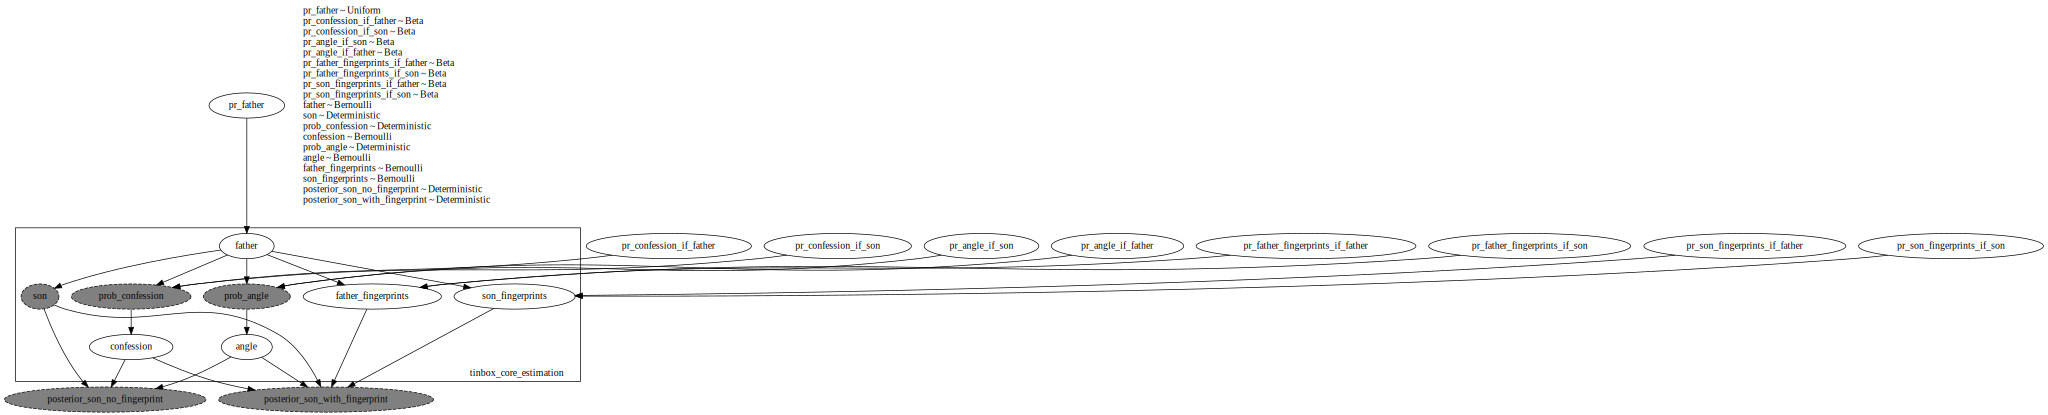

In [8]:

pyro.render_model(tinbox_model, render_deterministic=True, render_distributions=True)


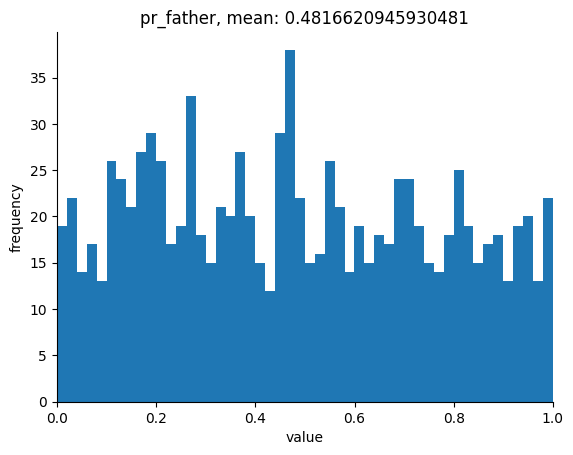

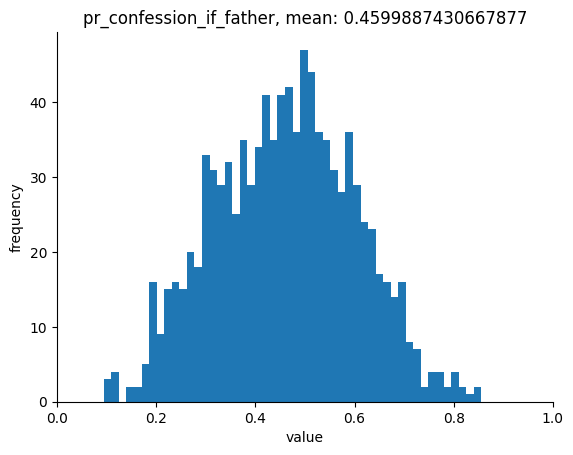

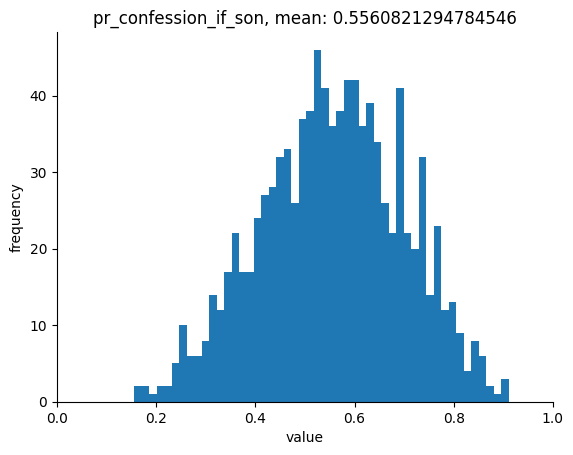

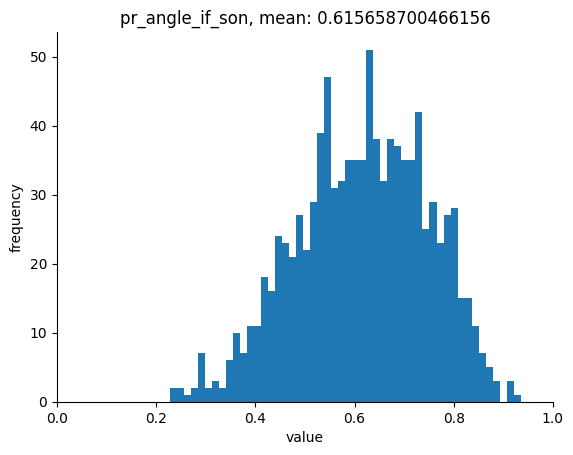

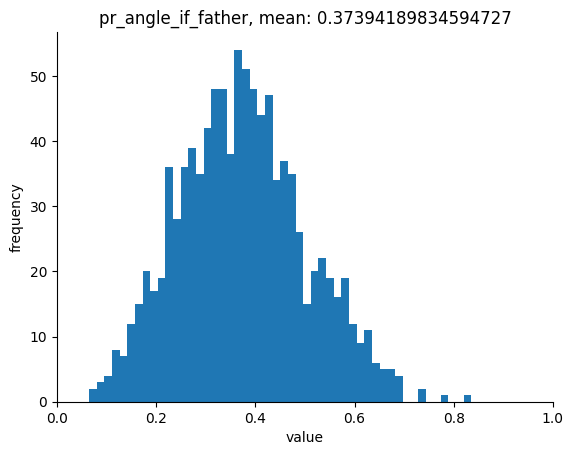

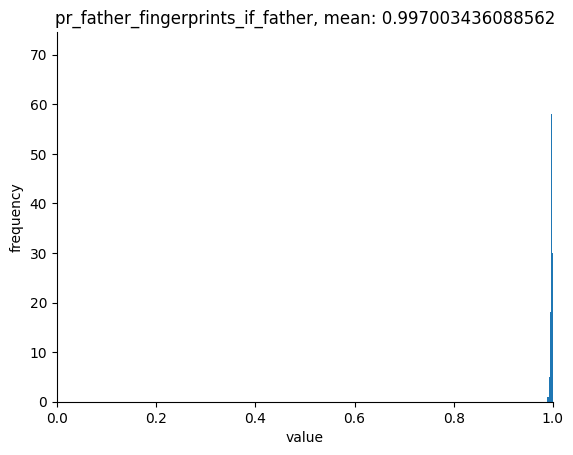

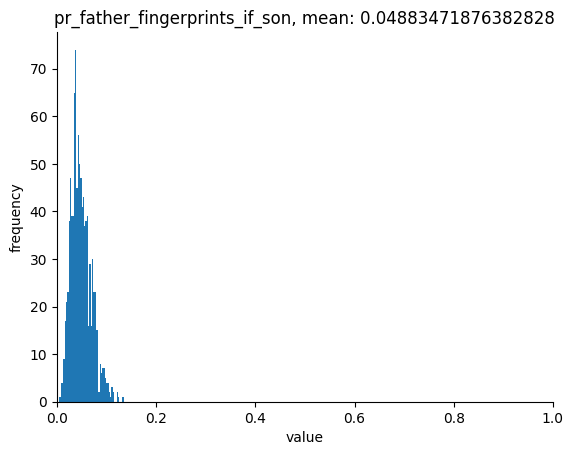

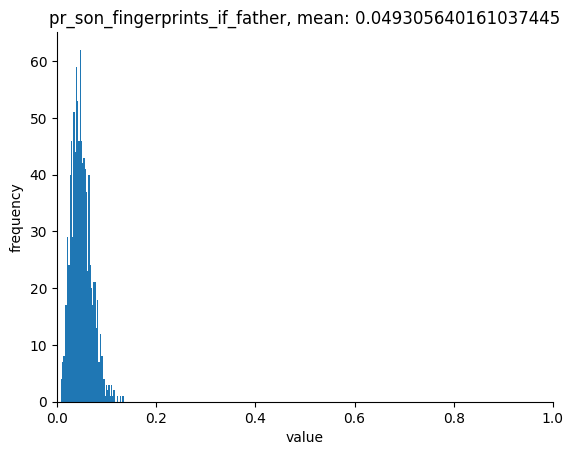

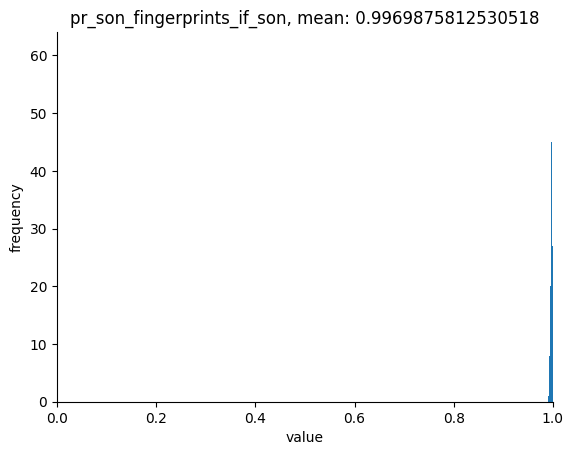

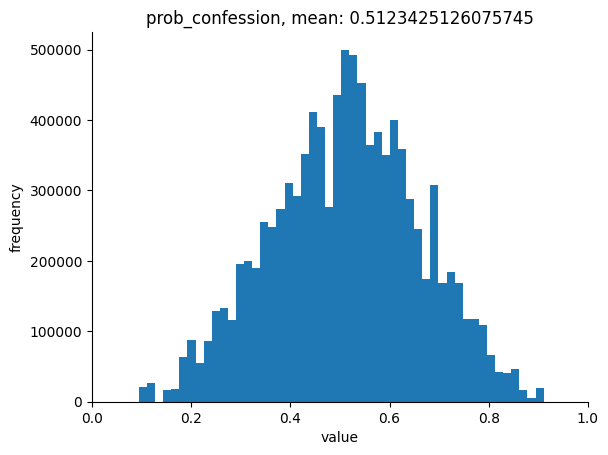

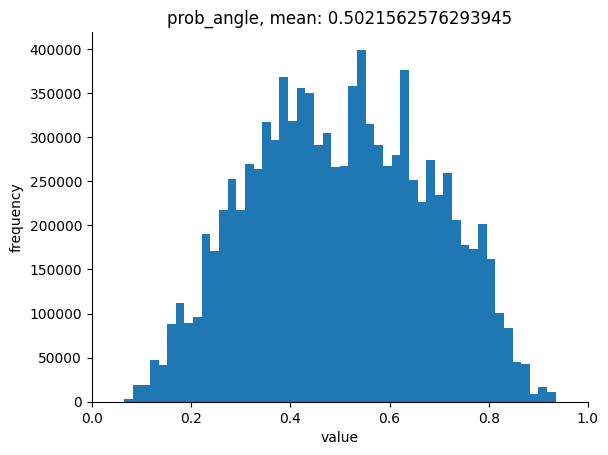

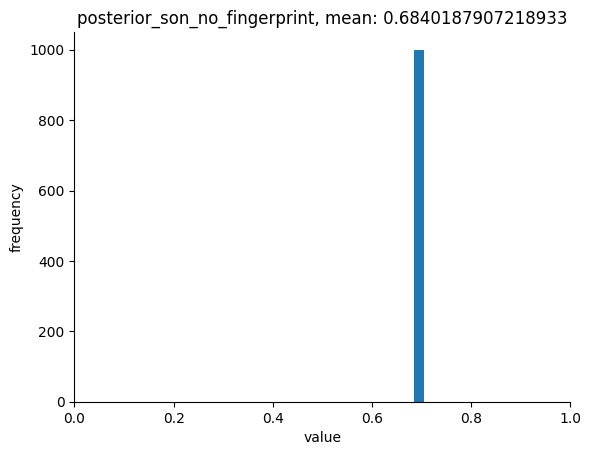

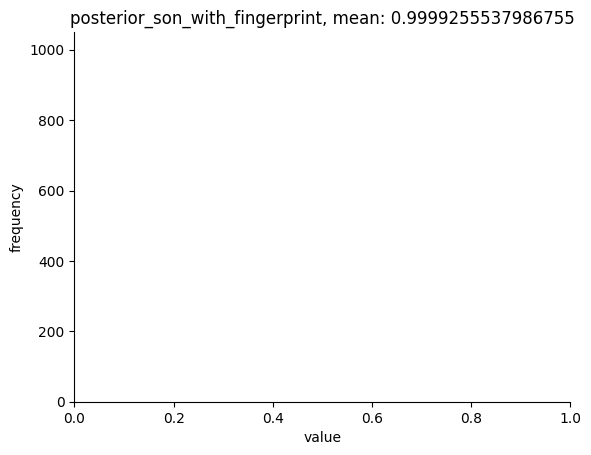

In [9]:
# with no intervention, the father is guilty with a probability of 0.5
# and the prob. of confession is equally distributed between 0.6 and 0.7 (point estimates)


def plot_site(nodes,site_name):
    if isinstance(nodes[site_name], torch.Tensor):
        value = nodes[site_name].flatten().detach().numpy()
    else:    
        value = nodes[site_name]['value'].flatten().detach().numpy()
    
    mean_of_value = value.mean()

    plt.hist(value, bins = 50)
    plt.title(f"{site_name}, mean: {mean_of_value}")
    plt.xlim(0,1)
    plt.xlabel('value')
    plt.ylabel('frequency')
    sns.despine()
    plt.show()

for key in nodes.keys():
    if key.startswith("pr") or key.startswith("posterior"):
        plot_site(nodes, key)

# plot_site(nodes,"prob_angle")
# plot_site(nodes, "prob_confession")
# plot_site(nodes, 'pr_father')
# plot_site(nodes, )
#plot_site(nodes, 'posterior_son_no_fingerprint')


In [ ]:


prior_father = [1 - priorDf["father"].mean(), priorDf["father"].mean()]
print("father, prior", prior_father) # father probability of not guilty and guilty

prior_weight_father = weight(prior_father) # weight of the father prior
print("weight_father_prior", prior_weight_father.round(3))


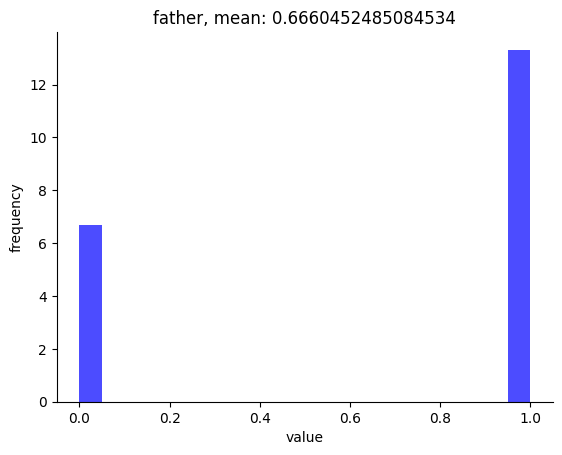

evidence_wo_tinbox_father [0.33395475149154663, 0.66604525]
weight_father_wo_tinbox 0.08108400090009193
difference in weights 0.08108296212424593


In [17]:
# evidence so far, no tinbox

# intervention: when father confesses and the angle of attack matches the father
evidence_wo_tinbox_Df = plot_from_nodes(nodes, 
                                        filters = {"confession": 1,
                                                   "angle": 1,
                                        },
                                        nodes_to_plot=["father"])


evidence_wo_tinbox_father = [1 - evidence_wo_tinbox_Df["father"].mean(), evidence_wo_tinbox_Df["father"].mean()]# probs. of not guilty and guilty
evidence_wo_tinbox_weight_father = weight(evidence_wo_tinbox_father)# weight of the father evidence so far

# the prob. that he is guilty is 0.66

print("evidence_wo_tinbox_father", evidence_wo_tinbox_father)
print("weight_father_wo_tinbox",  evidence_wo_tinbox_weight_father)
print("difference in weights", evidence_wo_tinbox_weight_father - prior_weight_father) # differnce in weights between the prior and the evidence so far

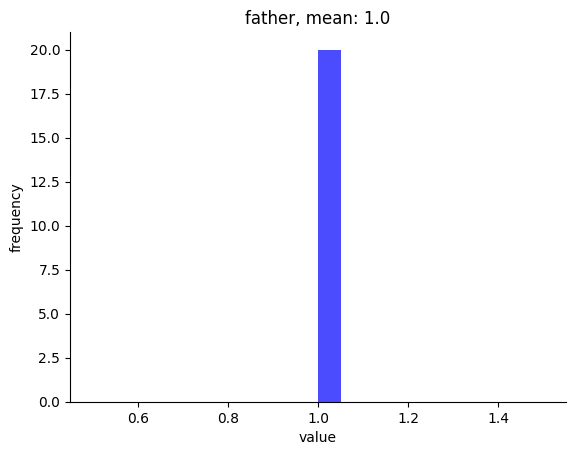

evidence_tinbox_f_father [0.0, 1.0]
evidence_tinbox_f_weight_father 1.0
difference in weights 0.9189159990999081


In [20]:
# suppose father's fingerprints on the tinbox

# simmilar to the previous case, but now we have the father's fingerprints on the tinbox and without son's fingerprints
evidence_tinbox_f_df = plot_from_nodes(nodes,
                                        filters = {"confession": 1,
                                                   "angle": 1,
                                                   "father_fingerprints": 1,
                                                   "son_fingerprints": 0,
                                        },
                                        nodes_to_plot=["father"])




evidence_tinbox_f_father = [1 - evidence_tinbox_f_df["father"].mean(), evidence_tinbox_f_df["father"].mean()]
evidence_tinbox_f_weight_father = weight(evidence_tinbox_f_father)
print("evidence_tinbox_f_father", evidence_tinbox_f_father)
print("evidence_tinbox_f_weight_father", evidence_tinbox_f_weight_father)

print("difference in weights", evidence_tinbox_f_weight_father - evidence_wo_tinbox_weight_father)

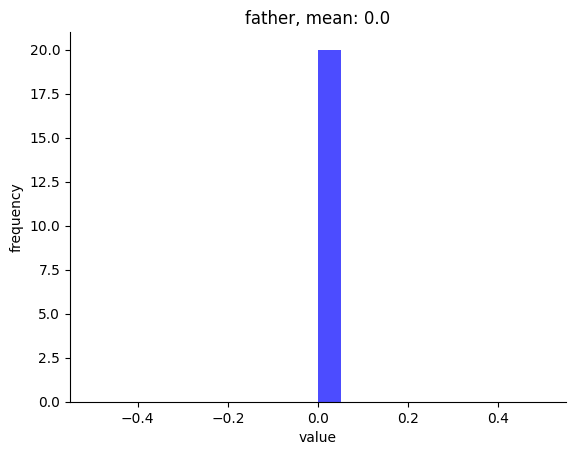

evidence_tinbox_f_father [1.0, 0.0]
evidence_tinbox_f_weight_father 1.0
difference in weights 0.9189159990999081


In [21]:
# suppose son's fingerprints on the tinbox, not father's

evidence_tinbox_s_df = plot_from_nodes(nodes,
                                        filters = {"confession": 1,
                                                   "angle": 1,
                                                   "father_fingerprints": 0,
                                                   "son_fingerprints": 1,
                                        },
                                        nodes_to_plot=["father"])




evidence_tinbox_s_father = [1 - evidence_tinbox_s_df["father"].mean(), evidence_tinbox_s_df["father"].mean()]
evidence_tinbox_s_weight_father = weight(evidence_tinbox_s_father)
print("evidence_tinbox_f_father", evidence_tinbox_s_father)
print("evidence_tinbox_f_weight_father", evidence_tinbox_s_weight_father)

print("difference in weights", evidence_tinbox_s_weight_father - evidence_wo_tinbox_weight_father)

In [10]:
# something to think about and experiment with potentially

# def samples_to_normalized_counts(samples, grid_length=100):

#     linspace = np.linspace(0, 1, grid_length)
#     counts, _ = np.histogram(samples, bins=linspace)
#     normalized_counts = counts / grid_length
#     return normalized_counts